In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from scipy.interpolate import griddata
import pyproj
from pyproj import Transformer
from datetime import datetime, timedelta
import os, fnmatch, glob
import cmocean 
import rasterio
from rasterio.plot import show
import sys
sys.path.append('/home/maltem/miniforge3/envs/opendrift/lib/python3.11/site-packages')
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.windblow import WindBlow
import geopy.distance

/home/maltem/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## Collect Model Data along the trajectory

#### Build a versatile tool to collect data from the various models

In [2]:
def makeWinddrift(model,seedlon,seedlat,initime,no_seeds):
    o = WindBlow(loglevel=20)  
    ofilename = 'tmp_transfer.nc'
    
    if model=='MET-AROME':
        
        year = datetime.strftime(initime, '%Y')
        month = datetime.strftime(initime, '%m')
        day = datetime.strftime(initime, '%d')
        
        fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/'
        fc_data_path=fc_data_path + year +"/"+ month  +"/"+ day+"/" 
        fc_file = fc_data_path + 'arome_arctic_det_2_5km_'+year+month+day+'T00Z.nc'

        reader_arome = reader_netCDF_CF_generic.Reader(fc_file)
        o.add_reader([reader_arome])

        #lat = 79.85;  lon = 18.5# 
        #lat = 79.75;  lon = 18  # 
        o.seed_elements(seedlon, seedlat, radius=2500, number=no_seeds, time=reader_arome.start_time)

        o.run(steps=4*48, time_step=900, time_step_output=3600, outfile=ofilename)

        for attribute, value in o.__dict__.items():
            #print(attribute, '=', value)
            if attribute=='history':
                a=value
        
        latw=np.array((a['lat'])); lonw=np.array((a['lon']));   
        
        return ofilename

In [3]:
# Find index on a irregular grid:
def findindex(alat,alon,plat,plon):
    #finding identical location of pos plat, plon in array alat[],alon[]
    abslat = np.abs(alat-plat)
    abslon = np.abs(alon-plon)
    c = np.maximum(abslon,abslat)
    x, y = np.where(c == np.min(c))
    #print(alats[x,y],alon[x,y])
    x=int(x)
    y=int(y)
   
    return (x,y)

In [4]:
def getModelTrajectoryForecast(model,initime,traj_filename):
    
    inDomain=True
    
    WindTraj = xr.open_mfdataset(traj_filename)
    
    ttime = WindTraj.time
    tlat  = np.squeeze(np.array(WindTraj.lat))
    tlon  = np.squeeze(np.array(WindTraj.lon))
    tray  = np.squeeze(np.array(WindTraj.trajectory))
    print('Number of trajectories',len(tray))
    print('Number of time steps',len(tlat[0,:]))
    
    t2m=np.zeros((len(tray),len(tlat[0,:])))
    sic=np.zeros((len(tray),len(tlat[0,:])))
    lat=np.zeros((len(tray),len(tlat[0,:])))
    lon=np.zeros((len(tray),len(tlat[0,:])))

    print(np.shape(t2m))
    WindTraj.close()
    if model=='MET-AROME':
        #initialization only at 00 for now
        
        year = datetime.strftime(initime, '%Y')
        month = datetime.strftime(initime, '%m')
        day = datetime.strftime(initime, '%d')
        
        fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/'
        fc_data_path=fc_data_path + year +"/"+ month  +"/"+ day+"/" 
        fc_file = fc_data_path + 'arome_arctic_det_2_5km_'+year+month+day+'T00Z.nc'      
        fc = xr.open_dataset(fc_file)
        
        [imax,jmax] = np.shape(fc['latitude'])
        
        for ens in range(len(tray)):
        
            for i in range(len(tlat[0,:])):

                [ix,jx] = findindex(fc['latitude'],fc['longitude'],tlat[ens,i],tlon[ens,i]) # For example for Longyearbyen
            
                if (ix==0 or jx == 0 or ix==imax or jx==jmax):
                    inDomain = False
                    #print ('Out of Domain',i)
                else:
                    inDomain= True
            
                if (inDomain):
            
                    fctime = fc.sel(time=ttime[i],method='nearest')
            
                    t2m_nc = fctime['air_temperature_2m'].isel(y=ix, x=jx)
                    sic[ens,i]=float(fctime['SFX_SIC'].isel(y=ix, x=jx))
                    t2m[ens,i]=float(t2m_nc.values)
                    lat[ens,i]=float(tlat[ens,i])
                    lon[ens,i]=float(tlon[ens,i])
                
                else:
                    t2m[ens,i]=np.nan
                    lat[ens,i]=np.nan
                    lon[ens,i]=np.nan
    fc.close()
    return WindTraj.time,lat,lon,np.array(t2m),np.array(sic)



### Run opendrift and forecast model temperature extraction:

In [41]:
#Good combinations:
#date = datetime.strptime('2024-04-12 10:00:00','%Y-%m-%d %H:%M:%S') 
#traj_filename = makeWinddrift('MET-AROME',17.7,79.94,date,20)

#date = datetime.strptime('2024-04-15 10:00:00','%Y-%m-%d %H:%M:%S') 
#traj_filename = makeWinddrift('MET-AROME',15,80.95,date,20)


# Set initial time
date = datetime.strptime('2024-04-14 10:00:00','%Y-%m-%d %H:%M:%S') 

#
#traj_filename = makeWinddrift('MET-AROME',18.,79.89,date,20)
#traj_filename = makeWinddrift('MET-AROME',17.7,79.94,date,20)
#traj_filename = makeWinddrift('MET-AROME',17.8,80.95,date,20)
traj_filename = makeWinddrift('MET-AROME',15.1,80.28,date,20)


11:45:28 INFO    opendrift.models.basemodel:515: OpenDriftSimulation initialised (version 1.11.13 / v1.11.13-11-gfa23a9f)
11:45:28 INFO    opendrift.readers.reader_netCDF_CF_generic:102: Opening dataset: /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/14/arome_arctic_det_2_5km_20240414T00Z.nc
11:45:31 INFO    opendrift.readers.reader_netCDF_CF_generic:314: Detected dimensions: {'time': 'time', 'x': 'x', 'y': 'y'}
11:45:31 INFO    opendrift.models.basemodel:2038: 2024-04-14 00:00:00 - step 1 of 192 - 20 active elements (0 deactivated)
11:45:31 INFO    opendrift.models.basemodel:2038: 2024-04-14 00:15:00 - step 2 of 192 - 20 active elements (0 deactivated)
11:45:31 INFO    opendrift.models.basemodel:2038: 2024-04-14 00:30:00 - step 3 of 192 - 20 active elements (0 deactivated)
11:45:31 INFO    opendrift.models.basemodel:2038: 2024-04-14 00:45:00 - step 4 of 192 - 20 active elements (0 deactivated)
11:45:31 INFO    opendrift.models.basemodel:2

11:45:34 INFO    opendrift.models.basemodel:2038: 2024-04-14 13:45:00 - step 56 of 192 - 20 active elements (0 deactivated)
11:45:34 INFO    opendrift.models.basemodel:2038: 2024-04-14 14:00:00 - step 57 of 192 - 20 active elements (0 deactivated)
11:45:34 INFO    opendrift.models.basemodel:2038: 2024-04-14 14:15:00 - step 58 of 192 - 20 active elements (0 deactivated)
11:45:34 INFO    opendrift.models.basemodel:2038: 2024-04-14 14:30:00 - step 59 of 192 - 20 active elements (0 deactivated)
11:45:34 INFO    opendrift.models.basemodel:2038: 2024-04-14 14:45:00 - step 60 of 192 - 20 active elements (0 deactivated)
11:45:34 INFO    opendrift.models.basemodel:2038: 2024-04-14 15:00:00 - step 61 of 192 - 20 active elements (0 deactivated)
11:45:34 INFO    opendrift.models.basemodel:2038: 2024-04-14 15:15:00 - step 62 of 192 - 20 active elements (0 deactivated)
11:45:34 INFO    opendrift.models.basemodel:2038: 2024-04-14 15:30:00 - step 63 of 192 - 20 active elements (0 deactivated)
11:45:34

11:45:36 INFO    opendrift.models.basemodel:2038: 2024-04-14 22:00:00 - step 89 of 192 - 20 active elements (0 deactivated)
11:45:36 INFO    opendrift.models.basemodel:2038: 2024-04-14 22:15:00 - step 90 of 192 - 20 active elements (0 deactivated)
11:45:36 INFO    opendrift.models.basemodel:2038: 2024-04-14 22:30:00 - step 91 of 192 - 20 active elements (0 deactivated)
11:45:36 WARNING opendrift.readers.basereader.structured:324: Data block from /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/14/arome_arctic_det_2_5km_20240414T00Z.nc not large enough to cover element positions within timestep. Buffer size (20) must be increased. See `Variables.set_buffer_size`.
11:45:36 INFO    opendrift.models.basemodel:2038: 2024-04-14 22:45:00 - step 92 of 192 - 20 active elements (0 deactivated)
11:45:36 WARNING opendrift.readers.basereader.structured:324: Data block from /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARC

11:45:37 INFO    opendrift.models.basemodel:2038: 2024-04-15 04:00:00 - step 113 of 192 - 20 active elements (0 deactivated)
11:45:37 INFO    opendrift.models.basemodel:2038: 2024-04-15 04:15:00 - step 114 of 192 - 20 active elements (0 deactivated)
11:45:37 WARNING opendrift.readers.basereader.structured:324: Data block from /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/14/arome_arctic_det_2_5km_20240414T00Z.nc not large enough to cover element positions within timestep. Buffer size (20) must be increased. See `Variables.set_buffer_size`.
11:45:37 INFO    opendrift.models.basemodel:2038: 2024-04-15 04:30:00 - step 115 of 192 - 20 active elements (0 deactivated)
11:45:37 WARNING opendrift.readers.basereader.structured:324: Data block from /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/14/arome_arctic_det_2_5km_20240414T00Z.nc not large enough to cover element positions within timestep. Buffer

11:45:39 INFO    opendrift.models.basemodel:2038: 2024-04-15 12:15:00 - step 146 of 192 - 20 active elements (0 deactivated)
11:45:39 INFO    opendrift.models.basemodel:2038: 2024-04-15 12:30:00 - step 147 of 192 - 20 active elements (0 deactivated)
11:45:39 INFO    opendrift.models.basemodel:2038: 2024-04-15 12:45:00 - step 148 of 192 - 20 active elements (0 deactivated)
11:45:39 INFO    opendrift.models.basemodel:2038: 2024-04-15 13:00:00 - step 149 of 192 - 20 active elements (0 deactivated)
11:45:39 INFO    opendrift.models.basemodel:2038: 2024-04-15 13:15:00 - step 150 of 192 - 20 active elements (0 deactivated)
11:45:39 INFO    opendrift.models.basemodel:2038: 2024-04-15 13:30:00 - step 151 of 192 - 20 active elements (0 deactivated)
11:45:39 INFO    opendrift.models.basemodel:2038: 2024-04-15 13:45:00 - step 152 of 192 - 20 active elements (0 deactivated)
11:45:39 INFO    opendrift.models.basemodel:2038: 2024-04-15 14:00:00 - step 153 of 192 - 20 active elements (0 deactivated)


### Load the corresponding remote sending sea-ice fields 

In [42]:
# Load visible MODIS satellite image
datetime_str = datetime.strftime(date, '%Y-%m-%d')
geotiff_path = '/home/maltem/work/python/SvalMIZ2024/data/snapshot-'+datetime_str+'T00_00_00Z.tif'
with rasterio.open(geotiff_path, 'r') as src:
    raster_crs = src.crs
    print(raster_crs)
    left, bottom, right, top = src.bounds
    landsat = src.read()[0, :, :]
    landsat = np.ma.masked_where(landsat <= 0,
                                 landsat,
                                 copy=True)
    landsat = (landsat - np.min(landsat)) / (np.max(landsat) - np.min(landsat))        
# Load SeaIce             -----------------------------------#
dir_seaiceproduct_hres= '/lustre/storeB/project/fou/hi/oper/barents_eps/archive/obs/'
file_name_stub         = 'barents_icec-obs_%s' #barents_icec-obs_20240415T00Z.nc
datetime_str = datetime.strftime(date, '%Y%m%d')
file_prename = file_name_stub % datetime_str
infile_name = glob.glob(dir_seaiceproduct_hres + file_prename + '*.nc')
if infile_name:
    IceIn = xr.open_mfdataset(infile_name)
    lats = np.array(IceIn['lat'])
    lons = np.array(IceIn['lon'])
    sicn = np.array(IceIn['ice_conc'])
    sicn=np.squeeze(np.where(sicn<0.1,np.nan,sicn))

    
#Load OMB data
OMBraw = xr.open_mfdataset('/home/maltem/work/python/SvalMIZ2024/data/cruise/2024_KVS_deployment.nc')        

EPSG:3413


In [43]:
time,lat,lon,t2m,sic=getModelTrajectoryForecast('MET-AROME',date,traj_filename)

Number of trajectories 20
Number of time steps 49
(20, 49)


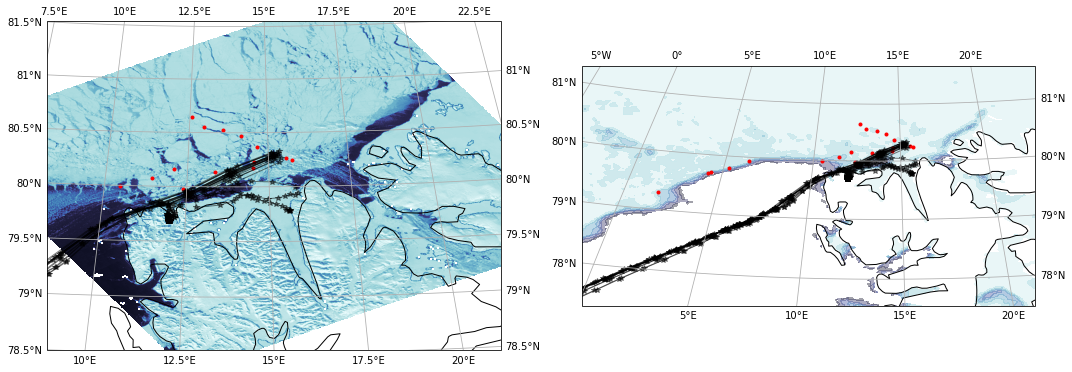

In [44]:
# Create the projection
plot_proj = ccrs.Orthographic(14,25)

fig, ax = plt.subplots(figsize=(15, 8),nrows=1,ncols=2,
                       subplot_kw={'projection': plot_proj})

ax[0].coastlines(resolution='50m')
ax[1].coastlines(resolution='50m')
ax[0].set_extent([9, 21, 78.5, 81.5], crs=ccrs.PlateCarree())
ax[1].set_extent([0, 21, 77.5, 81.5], crs=ccrs.PlateCarree())

# -- Subplot - 1- #
#    MODIS visible satellite picture
contour3 = ax[0].imshow(landsat, transform=ccrs.epsg(3413),cmap=cmocean.cm.ice,extent=(left, right, bottom, top))
# -- Subplot - 2- #
#    AMSR2 sea-ice contour
contour1 = ax[1].contourf(lons, lats, sicn, transform=ccrs.PlateCarree(), cmap=cmocean.cm.ice,alpha=0.4)

# 
startdate = date
timesteps_to_loop=1

for dt in range(timesteps_to_loop): #MAKE LOOP
    date = startdate + timedelta(hours=dt*1)
    #------------------------------------------------------------#
    #Find all buoys at date times closer than 29 minutes
    timenow = np.datetime64(date)
    timemask = np.int32(np.abs(np.array(OMBraw.time-timenow)).astype('timedelta64[m]'))<10

    for buoy_no in range(np.min(np.shape(timemask))):
        tb = np.where(timemask[buoy_no,:]); #tb = [x[0] for x in tb1]
        if tb:
            ax[0].scatter(OMBraw.lon[buoy_no,np.array(tb[0])],OMBraw.lat[buoy_no,np.array(tb[0])],color='r',marker='.',transform = ccrs.PlateCarree())
            ax[1].scatter(OMBraw.lon[buoy_no,np.array(tb[0])],OMBraw.lat[buoy_no,np.array(tb[0])],color='r',marker='.',transform = ccrs.PlateCarree())            
            
# Loop over all trajectories and plot:  
for ens in range(len(lat[:,0])):         
    ax[0].plot(list(np.squeeze(lon[ens,:])),list(np.squeeze(lat[ens,:])),'-',marker='*',linewidth=1,color='k',transform = ccrs.PlateCarree(),alpha=0.5)
    ax[1].plot(lon[ens,:],lat[ens,:],'-',marker='*',linewidth=1,color='k',transform = ccrs.PlateCarree(),alpha=0.5)
    
    
ax[0].gridlines(draw_labels=True)    
ax[1].gridlines(draw_labels=True)

plt.show()

# -- Subplot - 2- #

t2m_buoys=np.zeros((20,12)); t2m_buoys=t2m_buoys*np.nan
# Loop over all trajectories and find observations close-by
for ti in range(12): # Only the first 12 hours of the forecast
    timenow=time[ti]     
    for ens in range(len(lat[:,0])):
        timemask = np.int32(np.abs(np.array(OMBraw.time-timenow)).astype('timedelta64[m]'))<15
        for buoy_no in range(np.min(np.shape(timemask))):
            tb = np.where(timemask[buoy_no,:])
            if tb[0]:
                # Buoy Coordinates
                latb = np.array(OMBraw.lat[buoy_no,np.array(tb[0])])
                lonb = np.array(OMBraw.lon[buoy_no,np.array(tb[0])])
                # Trajectory Coordinates / ensemblermember&time - dependent
                # lon[ens,ti];lat[ens,ti]
                
                coords_1 = (latb, lonb)
                coords_2 = (lat[ens,ti],lon[ens,ti])

                if geopy.distance.geodesic(coords_1, coords_2).km < 5:
                    
                    t2m_buoys[ens,ti] = np.array(OMBraw.temp_1m_calibrated[buoy_no,np.array(tb[0])])
                


In [45]:
ensno  = len(lat[:,0])
leadno = 24


t2m_buoys=np.zeros((ensno,leadno)); t2m_buoys=t2m_buoys*np.nan
# Loop over all trajectories and find observations close-by
for ti in range(leadno): # Only the first leadno hours of the forecast
    timenow=time[ti]     
    for ens in range(len(lat[:,0])):
        timemask = np.int32(np.abs(np.array(OMBraw.time-timenow)).astype('timedelta64[m]'))<15
        for buoy_no in range(np.min(np.shape(timemask))):
            tb = np.where(timemask[buoy_no,:])
            if tb[0]:
                # Buoy Coordinates
                latb = np.array(OMBraw.lat[buoy_no,np.array(tb[0])])
                lonb = np.array(OMBraw.lon[buoy_no,np.array(tb[0])])
                # Trajectory Coordinates / ensemblermember&time - dependent
                # lon[ens,ti];lat[ens,ti]
                
                coords_1 = (latb, lonb)
                coords_2 = (lat[ens,ti],lon[ens,ti])
                if ~np.isnan(coords_2)[0]:
                    if geopy.distance.geodesic(coords_1, coords_2).km < 5:
                    
                        t2m_buoys[ens,ti] = np.array(OMBraw.temp_1m_calibrated[buoy_no,np.array(tb[0])])
                

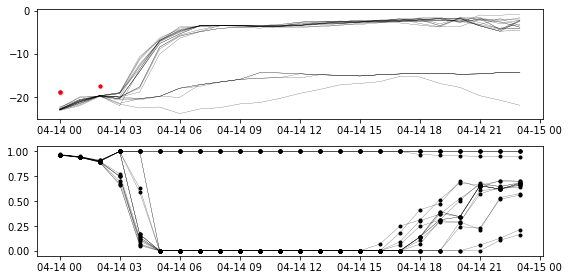

In [46]:
fig, ax = plt.subplots(figsize=(8, 4),nrows=2,ncols=1)
for ens in range(len(lat[:,0])):
    ax[1].plot(time[0:leadno],sic[ens,0:leadno],marker='.',linewidth=0.2,color='k')
    ax[0].plot(time[0:leadno],t2m[ens,0:leadno]-273.15,linewidth=0.2,color='k'),
    ax[0].scatter(time[0:leadno],t2m_buoys[ens,:],marker='*',s=10,color='r')
    ax[0].scatter(time[0:leadno],t2m_buoys[ens,:],marker='o',s=10,color='r')